In [ ]:
import zipfile
import os

zip_path = "label.zip"  # 업로드한 파일명
extract_dir = "unzipped"  # 압축을 풀 디렉터리 이름

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"압축 해제 완료: {extract_dir} 디렉터리에 저장됨")

압축 해제 완료: unzipped 디렉터리에 저장됨


데이터셋 로딩 및 분할을 시작합니다...
Found 3060 files belonging to 4 classes.
Using 2448 files for training.
Found 3060 files belonging to 4 classes.
Using 612 files for validation.
감지된 클래스: ['0_off', '1_green', '2_yellow', '3_red']

전이 학습 모델(MobileNetV2)을 구축합니다...


/tmp/ipython-input-3-1065010027.py:67: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(



모델을 컴파일하고 초기 학습을 시작합니다...
Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.6005 - loss: 0.9792 - val_accuracy: 0.9247 - val_loss: 0.2827
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9336 - loss: 0.2241 - val_accuracy: 0.9349 - val_loss: 0.2059
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9423 - loss: 0.1694 - val_accuracy: 0.9521 - val_loss: 0.1498
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9613 - loss: 0.1188 - val_accuracy: 0.9589 - val_loss: 0.1364
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9702 - loss: 0.1013 - val_accuracy: 0.9795 - val_loss: 0.1093
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9736 - loss: 0.0784 - val_accuracy: 0.9692 - val_loss: 0.1009
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9678 - loss: 0.0928 - val_accuracy: 0.9726 - val_loss: 0.0894
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9736 - loss: 0.076

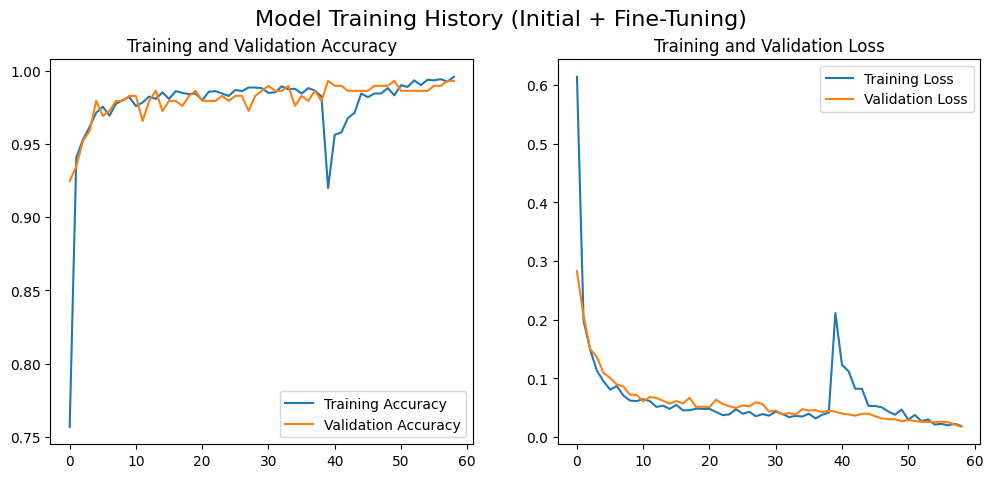


모든 작업이 완료되었습니다.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
import pathlib

# --- 1. 기본 설정값 지정 ---
# 데이터가 있는 폴더의 경로를 지정해주세요.
# pathlib.Path를 사용하면 어떤 운영체제에서도 경로가 잘 동작합니다.
data_dir = pathlib.Path('/content/unzipped/분류라벨링')

# 모델 학습을 위한 파라미터 설정
batch_size = 32
img_height = 180
img_width = 180

# --- 2. 데이터셋 준비 및 분할 ---
print("데이터셋 로딩 및 분할을 시작합니다...")

# image_dataset_from_directory를 사용하여 훈련/검증 데이터셋 생성
# 전체 데이터의 80%를 훈련용으로, 20%를 검증/테스트용으로 사용
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# 클래스 이름 확인
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"감지된 클래스: {class_names}")

# 검증 세트에서 테스트 세트 분리 (예: 검증 세트의 절반을 테스트용으로 사용)
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 2)
val_ds = validation_ds.skip(val_batches // 2)

# 데이터셋 성능 최적화 (캐싱, 프리페치)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# --- 3. 모델 구축 (전이 학습) ---
print("\n전이 학습 모델(MobileNetV2)을 구축합니다...")

# 데이터 증강 및 전처리 레이어 정의
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name='data_augmentation')

# MobileNetV2 기본 모델 로드
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

# 초기에는 기본 모델의 가중치를 고정 (동결)
base_model.trainable = False

# 모델 조립
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x) # MobileNetV2 전용 전처리
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)

# --- 4. 모델 컴파일 및 초기 학습 ---
print("\n모델을 컴파일하고 초기 학습을 시작합니다...")
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# 조기 종료 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 초기 학습 진행 (진행률 막대가 자동으로 표시됩니다)
initial_epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=[early_stopping]
)

# --- 5. 미세 조정 (Fine-Tuning) ---
print("\n모델 미세 조정을 시작합니다...")

# 기본 모델의 동결 해제 및 상위 일부 레이어만 학습 가능하게 설정
base_model.trainable = True
fine_tune_at = -20 # 마지막 20개 레이어만 학습
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 매우 낮은 학습률로 다시 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# 미세 조정 학습 진행
fine_tune_epochs = 20
total_epochs = history.epoch[-1] + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stopping]
)

# --- 6. 최종 평가 및 결과 시각화 ---
print("\n테스트 데이터셋으로 최종 모델을 평가합니다...")
loss, accuracy = model.evaluate(test_ds)
print(f"최종 테스트 정확도: {accuracy:.2%}")

# 학습 과정 시각화 (정확도 및 손실)
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.suptitle("Model Training History (Initial + Fine-Tuning)", fontsize=16)
plt.savefig('training_history_final.png')
print("\n학습 과정 그래프가 'training_history_final.png' 파일로 저장되었습니다.")
plt.show()

print("\n모든 작업이 완료되었습니다.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


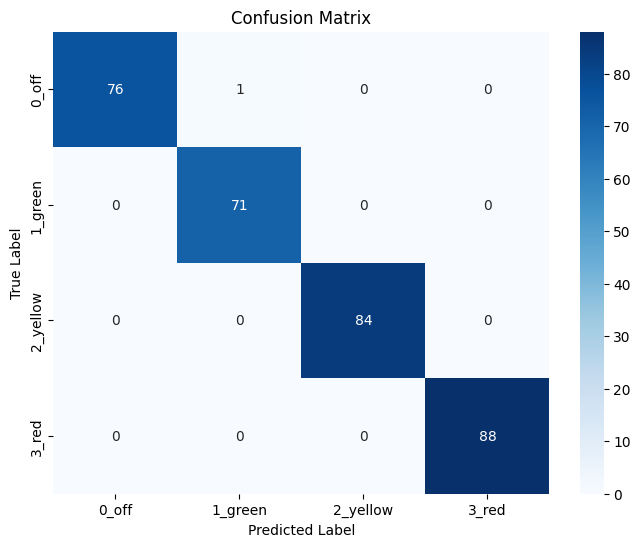

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels and predictions from the test dataset
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())
    preds = model.predict(images)
    predictions.extend(np.argmax(preds, axis=1))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


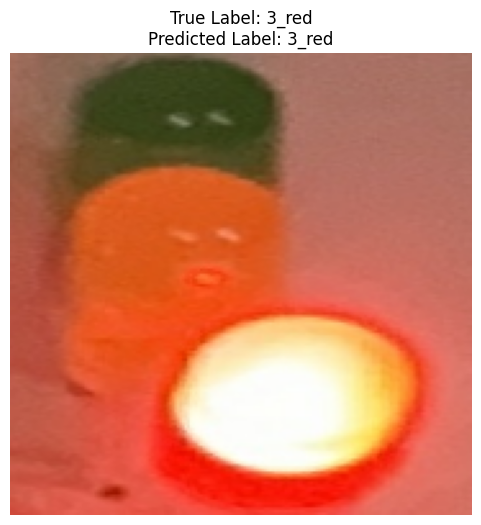

In [ ]:
import matplotlib.pyplot as plt

# Get one batch from the test dataset
for images, labels in test_ds.take(1):
    # Take the first image and its label from the batch
    first_image = images[0].numpy().astype("uint8")
    first_label = labels[0].numpy()

    # Make a prediction for the first image
    prediction = model.predict(np.expand_dims(first_image, axis=0))
    predicted_label = np.argmax(prediction)

    # Display the image and the prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(first_image)
    plt.title(f"True Label: {class_names[first_label]}\nPredicted Label: {class_names[predicted_label]}")
    plt.axis("off")
    plt.show()

    # Break the loop after processing the first batch
    break

Displaying images misclassified between 'green' and 'off':
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Misclassified: True Label = 0_off, Predicted Label = 1_green


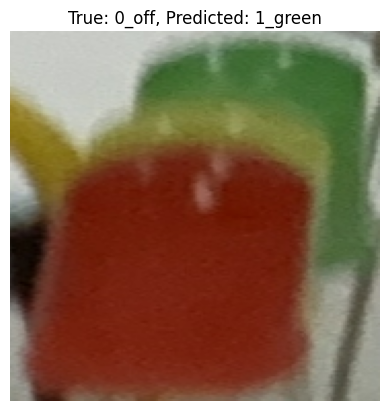

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the classes of interest
class_green_index = class_names.index('1_green')
class_off_index = class_names.index('0_off')

print("Displaying images misclassified between 'green' and 'off':")

# Iterate through the test dataset
for images, labels in test_ds:
    preds = model.predict(images)
    predicted_labels = np.argmax(preds, axis=1)

    # Check for misclassifications between 'green' and 'off' in the current batch
    for i in range(images.shape[0]):
        true_label = labels[i].numpy()
        predicted_label = predicted_labels[i]

        # Case 1: True label is 'green' but predicted is 'off'
        if true_label == class_green_index and predicted_label == class_off_index:
            print(f"Misclassified: True Label = {class_names[true_label]}, Predicted Label = {class_names[predicted_label]}")
            plt.figure()
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"True: {class_names[true_label]}, Predicted: {class_names[predicted_label]}")
            plt.axis("off")
            plt.show()

        # Case 2: True label is 'off' but predicted is 'green'
        elif true_label == class_off_index and predicted_label == class_green_index:
            print(f"Misclassified: True Label = {class_names[true_label]}, Predicted Label = {class_names[predicted_label]}")
            plt.figure()
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"True: {class_names[true_label]}, Predicted: {class_names[predicted_label]}")
            plt.axis("off")
            plt.show()